# Imports 

In [207]:
import numpy as np
from pathlib import Path
import tarfile
import pandas as pd

In [126]:
def get_data():
    '''
    checks if there's files with rna
    if there's not, downloads archive with RNA STRAND database and extracting them.
    
    ct files are now in the folder:
    ./data/RNA_STRAND_data/all_ct_files/
    '''
    curr_dir = Path('./')
    path = curr_dir/'all_ct_files'
    try:
        f = open(path/'ASE_00001.ct')
    except FileNotFoundError:
        try:
            my_tar = tarfile.open(curr_dir/'RNA_STRAND_data.tar.gz')
            my_tar.close()
        except FileNotFoundError:
            !wget http://www.rnasoft.ca/strand/download/RNA_STRAND_data.tar.gz
            
        !tar -xvf RNA_STRAND_data.tar.gz RNA_STRAND_data/all_ct_files -C curr_dir/'data' --strip 1 
            
    try:
        f = open(path/'ASE_00001.ct')
        print('RNA_STRAND is ok')
    except FileNotFoundError:
        print('Something went wrong with your data.\nTry to download and extract manually.')

    return path

## Get data

In [127]:
data_dir = get_data()

RNA_STRAND is ok


In [276]:
ct_fname = data_dir/'ASE_00001.ct'#'PDB_00285.ct'#'ASE_00001.ct'

In [277]:
dot_fname = 'ct2dot.txt'

In [278]:
df = pd.read_csv(ct_fname,  skiprows = 4, header = None)
ct = df[0].str.split(expand = True)[[1, 2, 3, 4, 5]]
ct.columns = ['let', 'prev', 'next', 'add', 'self']

pr_s= ct['let']

pr_str = ""
pr_str = pr_str.join(pr_s.values)
f = open(dot_fname)
lns = f.readlines()
s_str = lns[2][:-1]

assert( len(s_str)==len(pr_str))

In [279]:
s_list = [ch for ch in s_str]

In [280]:
ct['br'] = s_list

In [281]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ct)

,let,prev,next,add,self,br
0,g,0,2,0,1,.
1,a,1,3,0,2,.
2,g,2,4,0,3,.
3,g,3,5,0,4,.
4,a,4,6,0,5,.
5,a,5,7,261,6,(
6,a,6,8,260,7,(
7,g,7,9,259,8,(
8,u,8,10,0,9,.
9,c,9,11,258,10,(


In [241]:
from tqdm.notebook import tqdm

In [251]:
import os
directory = data_dir

for filename in tqdm(os.listdir(directory)):
    try:
        df = pd.read_csv(directory/filename,  skiprows = 4, header = None)
        ct = df[0].str.split(expand = True)
        if len(ct[1].unique()) >8:
            print(filename, '\n', ct[1].unique())
    except FileNotFoundError:
        pass

SPR_00380.ct 
 ['G' 'U' 'C' 'A' '(' 'R' '6' '?' ']' 'P' 'B']
SPR_00178.ct 
 ['G' 'A' 'C' 'U' 'D' '$' 'H' 'P' '7' 'T']
SPR_00040.ct 
 ['G' 'U' 'C' 'A' 'L' 'P' 'D' '#' '.' 'B' '8' '7' '?' 'T' '"']
SPR_00476.ct 
 ['G' 'A' 'C' 'U' 'K' 'L' '#' 'D' 'R' 'P' 'B' 'Z' '7' '"']
SPR_00467.ct 
 ['G' 'U' 'C' 'K' 'P' 'A' 'D' 'R' 'I' '7' 'T' '"']
SPR_00004.ct 
 ['G' 'C' 'A' 'U' 'L' '?' ']' 'P' 'B']
SPR_00489.ct 
 ['A' 'G' 'U' 'D' 'C' 'P' '!' 'H' 'T']
SPR_00474.ct 
 ['G' 'U' 'C' 'A' 'P' 'D' 'L' 'B' 'I' '?' '7' '"']
SPR_00071.ct 
 ['G' 'C' 'U' 'A' 'D' '#' '*' 'P' '7' '.' 'T']
CRW_00007.ct 
 ['c' 'a' 'g' 'u' 'G' 'A' 'C' 'U' 'n']
SPR_00193.ct 
 ['G' 'C' 'U' 'A' 'L' 'D' 'R' '6' 'K' '?' 'T' 'P' '"']
SPR_00049.ct 
 ['G' 'C' 'A' 'U' '#' 'D' 'N' '?' 'T' 'P']
SPR_00502.ct 
 ['A' 'G' 'C' 'U' 'P' 'L' 'B' 'H' '"']
CRW_00627.ct 
 ['N' 'g' 'u' 'c' 'a' 'U' 'G' 'A' 'C']
SPR_00412.ct 
 ['G' 'U' 'A' 'C' 'M' 'D' 'R' "'" '+' 'J' '=' 'T' 'P' '"']
SPR_00388.ct 
 ['G' 'A' 'C' '4' 'U' 'D' '"' 'P' 'T']
SPR_00387.ct 
 ['G' 'A' 

SPR_00464.ct 
 ['G' 'U' 'C' 'A' 'L' 'P' 'D' '7' '?' 'T' '"']
SPR_00041.ct 
 ['U' 'C' 'L' 'K' 'G' 'A' 'P' 'D' '8' '?' 'T']
SPR_00284.ct 
 ['G' 'U' 'K' 'L' 'C' 'A' 'D' 'X' 'R' 'P' 'B' 'E' '7' '?' 'T' '"']
SPR_00156.ct 
 ['G' 'C' 'A' 'U' '#' 'D' '6' '7' 'F' 'P' '"']
SPR_00221.ct 
 ['G' 'C' 'A' 'U' 'D' '#' ';' 'P' 'T']
SPR_00094.ct 
 ['G' 'C' 'A' 'U' 'L' 'D' 'R' 'P' 'B' '#' 'K' '7' '?' 'T' '"']
SPR_00003.ct 
 ['G' 'C' 'U' 'A' '?' ']' 'P' 'B' 'O']
SPR_00444.ct 
 ['G' 'C' 'U' 'K' 'L' 'A' 'D' 'R' "'" 'I' '6' '?' 'P' '"']
SPR_00347.ct 
 ['G' 'U' 'C' 'A' 'R' 'P' 'K' '?' ']' 'B' 'O']
ASE_00072.ct 
 ['U' 'C' 'G' 'A' 'a' 'c' 'g' 'x' 'u']
CRW_00640.ct 
 ['N' 'c' 'a' 'g' 'u' 'U' 'C' 'G' 'A']
SPR_00531.ct 
 ['A' 'G' 'C' 'U' 'K' 'L' '6' '7' 'D' '?' '"']
SPR_00382.ct 
 ['G' 'C' 'A' 'U' '(' 'R' '?' ']' 'P' 'B' 'O']
SPR_00104.ct 
 ['G' 'C' 'U' 'A' 'L' 'P' '?' ']' 'B' 'O']
SPR_00537.ct 
 ['A' 'G' 'C' 'U' 'K' 'L' '6' '7' 'D' '?' 'P' '"']
SPR_00487.ct 
 ['G' 'A' 'U' 'L' 'D' 'C' '!' '+' 'P']
SPR_00350.ct 
 [

ParserError: Error tokenizing data. C error: Expected 1 fields in line 38, saw 2


In [236]:
ct['let'].unique()

array(['g', 'a', 'u', 'c', 'U', 'C', 'A', 'G'], dtype=object)

In [232]:
# Python3 code to Check for 
# balanced parentheses in an expression 
def check(my_string): 
    brackets = ['()', '{}', '[]', '<>'] 
    while any(x in my_string for x in brackets): 
        for br in brackets: 
            my_string = my_string.replace(br, '') 
    return not my_string 

string = s_str.replace('.', '')
print(string, "-", "Balanced"
    if check(string) else "Unbalanced") 


((((((((((((<<<<<(((((((((()))))((((()))))((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))))))))((((((((((((((>>>>>)))))))))))))))))))))) - Unbalanced


In [234]:
s_str.replace('<', '[').replace('>', ']')

'.....(((.(((((((((.[[[[[.((((((((((....)))))(((((.....)))))((...((((............(((((((((((................((...((((((((((....))))))))))..))........))))))))))).......)))).)))))))))))...((.((((((((..((((..]]]]]))))))))))))...))...........................)))))))).'

In [ ]:
<<<<<(((((((((()))))((((()))))((((((((((((((((((((((((((((())))))))))))))))))))))))))))))))))((((((((((((((>>>>>))))))))))))))

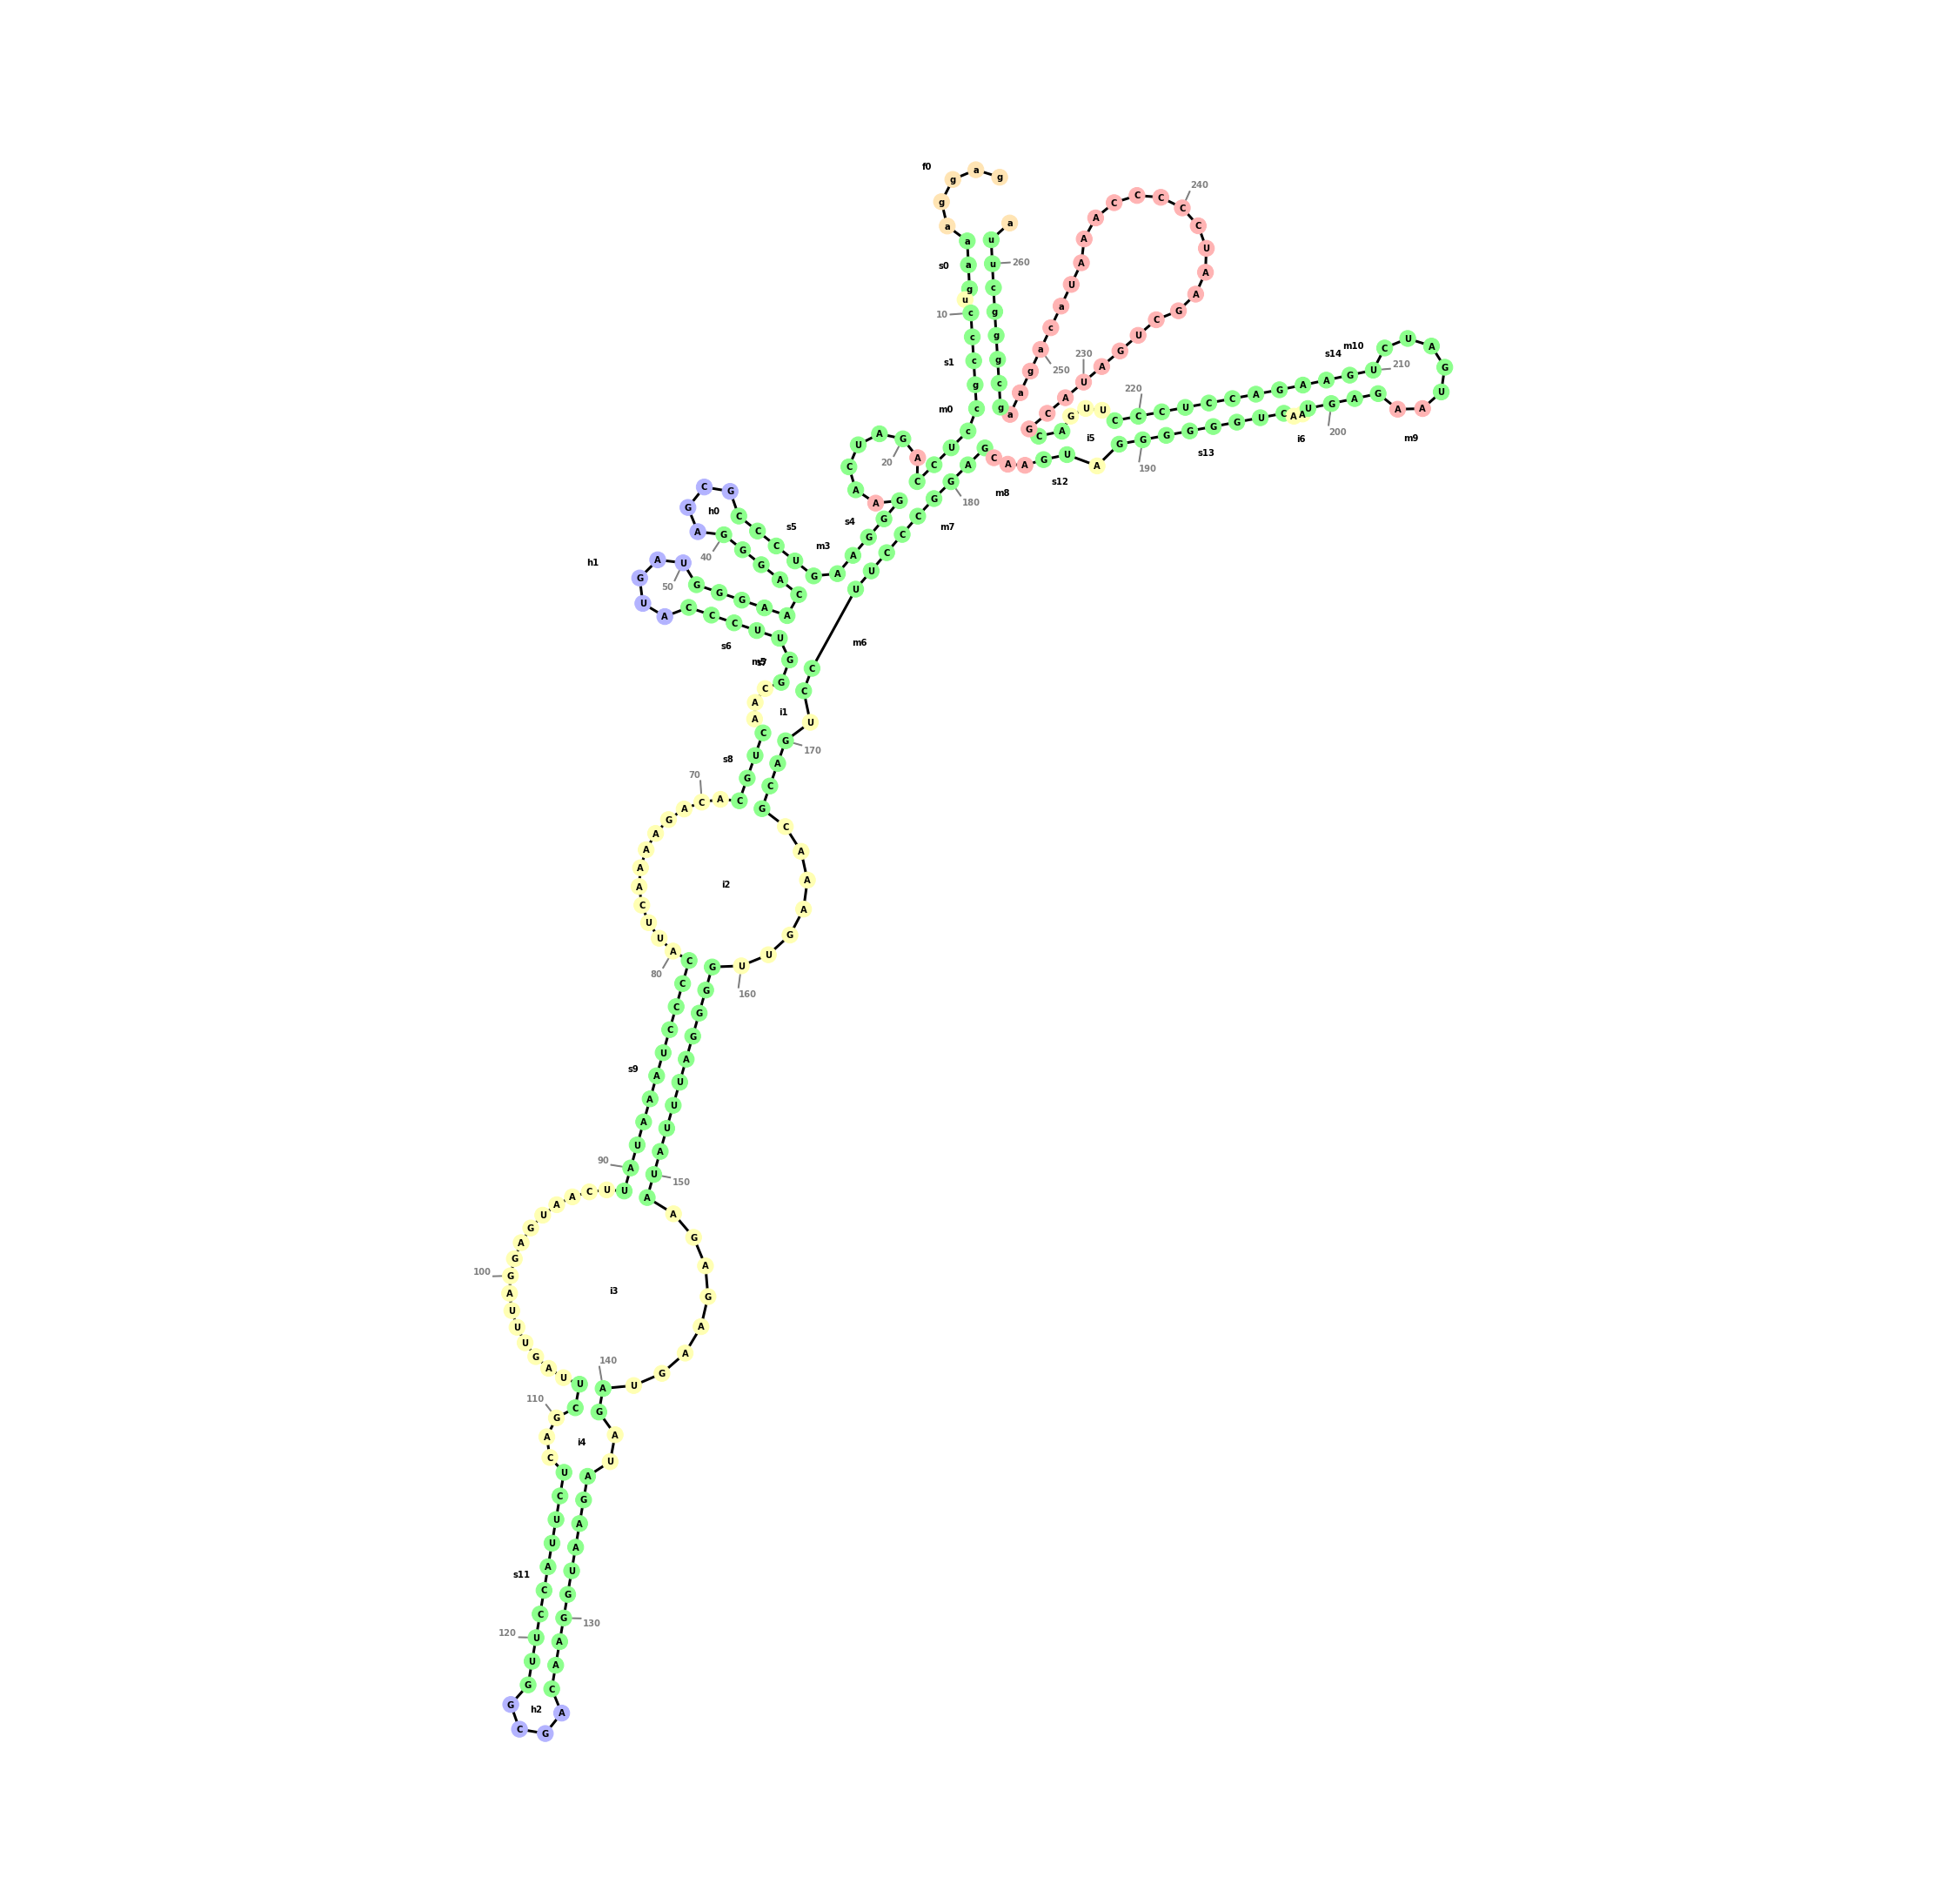

In [268]:
import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi

plt.figure(figsize = (40, 40))
cg = forgi.load_rna(dot_fname, allow_many=False)
fvm.plot_rna(cg, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
plt.show()

In [266]:
ss = '.....(((.(((((((((.<<<<<.((((((((((....)))))(((((.....)))))((...((((............(((((((((((................((...((((((((((....))))))))))..))........))))))))))).......)))).)))))))))))...((.((((((((..((((..>>>>>))))))))))))...))...........................)))))))).'

In [273]:
s_str in ss

True

# ct to dot